# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
import joblib
import seaborn as sn

# Choose options
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True

In [2]:
PROCESS_IMAGES = True
PROCESS_DATA = True

# List images

In [3]:
path = os.getcwd()
os.chdir(path)
sys.path.append(path)
sys.path.append(os.path.join(path, 'scripts'))

path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'excentricity', 'perimeter', 'curvature_coef'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    center_dist_col = mix.pop('center distance')
    mix.insert(15, 'weight', weight_col)
    mix.insert(16, 'centroid_x', centroid_x_col)
    mix.insert(17, 'centroid_y', centroid_y_col)
    mix.insert(18, 'center distance', center_dist_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

Generated data


,area,x,y,width,height,MA,ma,centroid_x,centroid_y,orientation,% area,center distance,excentricity,perimeter,curvature_coef
uuid,,,,,,,,,,,,,,,
0018b76693a14e20bce3027ff67dc055,273025.289744,196,119,576,346,304.146881,563.124084,258.377880,474.895100,-1.348229,50.015605,54.111530,1.643094,1727.474300,0.733157
00607e166c6e4054ab75451aacfbe32d,265083.619523,186,118,592,339,307.100464,574.335022,257.150605,476.758842,-1.407047,51.423913,55.476469,1.378308,1757.658066,0.741016
00635ae09a834ebf86ee85c58c12ff82,201016.798552,109,108,565,245,250.569244,523.746887,235.902665,407.500741,-1.551654,49.959682,17.000402,0.510114,1552.628628,0.666081
0066778f47734ca7a71be790f562c551,271063.185330,195,120,578,344,306.356812,563.428528,259.034342,475.183414,-1.366295,50.484331,54.608132,1.571729,1733.131154,0.736683
006d8cf500f14647a8de9ecf71951066,194461.430407,203,77,441,359,214.100098,504.326263,249.268163,400.243665,-1.016888,41.053033,25.500242,1.776215,1436.261097,0.854646


Loaded data


,uuid,id,sex,weight
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,24.5
1,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1
2,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5
3,3c4dcc3c6d83425dab0d0acd75227f99,0236,0,25.5
4,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8


Final data


,uuid,id,sex,area,x,y,width,height,MA,ma,orientation,% area,excentricity,perimeter,curvature_coef,weight,centroid_x,centroid_y,center distance
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,103,105,564,312,226.871475,589.829285,-1.305798,46.219501,0.838312,1797.356550,0.928812,24.5,291.266698,390.794758,61.080786
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,80,202,648,256,217.185989,681.104919,1.441417,58.533350,1.375974,1741.817446,0.969556,27.1,328.944662,427.000459,88.995256
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,195,103,569,324,167.003387,671.221436,1.183508,36.034621,0.864987,1568.812394,0.853786,25.5,270.915334,489.139166,72.103182
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,117,181,613,210,188.982895,637.330017,1.520453,60.039439,0.751995,1589.508790,0.977120,25.8,288.285815,444.695562,52.534048
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,171,96,510,345,196.767181,568.790527,-1.087220,41.696390,0.698404,1437.391040,0.994845,25.5,297.283394,422.638323,57.299576


# Process data

Load final data


,uuid,id,sex,area,x,y,width,height,MA,ma,orientation,% area,excentricity,perimeter,curvature_coef,weight,centroid_x,centroid_y,center distance
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,103,105,564,312,226.871475,589.829285,-1.305798,46.219501,0.838312,1797.356550,0.928812,24.5,291.266698,390.794758,61.080786
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,80,202,648,256,217.185989,681.104919,1.441417,58.533350,1.375974,1741.817446,0.969556,27.1,328.944662,427.000459,88.995256
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,195,103,569,324,167.003387,671.221436,1.183508,36.034621,0.864987,1568.812394,0.853786,25.5,270.915334,489.139166,72.103182
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,117,181,613,210,188.982895,637.330017,1.520453,60.039439,0.751995,1589.508790,0.977120,25.8,288.285815,444.695562,52.534048
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,171,96,510,345,196.767181,568.790527,-1.087220,41.696390,0.698404,1437.391040,0.994845,25.5,297.283394,422.638323,57.299576


X data


,sex,area,x,y,width,height,MA,ma,orientation,% area,excentricity,perimeter,curvature_coef
558,0,231013.914632,177,53,646,272,252.826218,647.670166,1.417359,52.529491,0.636108,1854.025597,0.607272
30,1,320181.602811,217,169,563,198,176.181671,586.050293,-1.538351,60.111300,0.717280,1507.910811,0.905903
1095,1,218591.446118,162,10,639,316,208.150696,692.638794,-1.337600,43.389722,2.001026,1819.432670,0.988460
1143,1,193795.431632,224,60,450,340,308.911194,445.458862,-1.256972,56.785991,0.901422,1620.184977,0.811402
247,0,303012.182976,154,37,517,386,163.114044,639.598877,0.979411,31.890805,1.560757,1475.498685,0.958915


y data


,weight
558,18.9
30,25.8
1095,16.0
1143,16.1
247,24.2


Correlation matrix


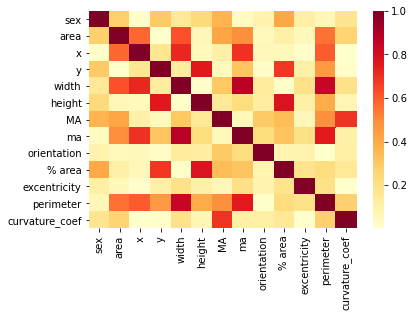

In [5]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'excentricity', 'perimeter', 'curvature_coef'])
print("Load final data")
display(file_data.head())
file_data = shuffle(file_data)

X = file_data.loc[:, 'sex':'curvature_coef']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    bayesianRidge = BayesianRidge()
    linearRegression = LinearRegression()
    extratrees = ExtraTreesRegressor()
    adaboost = AdaBoostRegressor 
    bagging= BaggingRegressor()
    gradientboost = GradientBoostingRegressor()
    randomForest = RandomForestRegressor()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[bayesianRidge]},
                      {'classifier':[linearRegression]},
                      {'classifier':[extratrees]},
                      {'classifier':[adaboost]},
                      {'classifier':[bagging]},
                      {'classifier':[gradientboost]},
                      {'classifier':[randomForest]}      
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
                          'neg_mean_squared_log_error', 'neg_median_absolute_error',  'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'bayesianRidge':bayesianRidge,
                 'extratrees': extratrees,
                 'adaboost': adaboost,
                 'bagging': bagging,
                 'gradientboost': gradientboost,
                 'randomForest': randomForest,
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
else:
    #Load last model
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    bayesianRidge = models['bayesianRidge']
    linearRegression = models['linearRegression']
    extratrees = models['extratrees']
    adaboost = models['adaboost']
    bagging= models['bagging']
    gradientboost = models['gradientboost']
    randomForest = models['randomForest']

In [6]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
resultados.head()
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'mean_test_neg_mean_poisson_deviance', 'mean_test_neg_mean_gamma_deviance',
                             'mean_test_neg_root_mean_squared_error', 'mean_test_neg_mean_squared_log_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 'mean_test_neg_mean_absolute_error',
                         'mean_test_neg_root_mean_squared_error', 'mean_test_neg_mean_squared_log_error', 'mean_test_neg_mean_poisson_deviance', 'mean_test_neg_mean_gamma_deviance',
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error', 'std_test_neg_mean_absolute_error',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_explained_variance', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo).round(4)

Best model: ExtraTreesRegressor()
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,mean_test_neg_mean_squared_log_error,mean_test_neg_mean_poisson_deviance,mean_test_neg_mean_gamma_deviance,std_test_r2,std_test_explained_variance,std_test_max_error,std_test_neg_mean_absolute_error
param_classifier,,,,,,,,,,,,
ExtraTreesRegressor,0.9825,0.9828,-4.0605,-0.1886,-0.5924,-0.0008,-0.0189,-0.0009,0.0138,0.0135,1.5729,0.0586
RandomForestRegressor,0.9582,0.9587,-5.8535,-0.3433,-0.9261,-0.0020,-0.0465,-0.0023,0.0279,0.0274,2.1434,0.1022
BaggingRegressor,0.9518,0.9524,-6.3430,-0.3594,-0.9905,-0.0024,-0.0549,-0.0028,0.0320,0.0314,2.6578,0.1083
GradientBoostingRegressor,0.9429,0.9437,-5.6412,-0.6480,-1.1260,-0.0028,-0.0636,-0.0031,0.0239,0.0230,1.6952,0.1087
LinearRegression,0.7081,0.7096,-9.5387,-1.8093,-2.5955,-0.0158,-0.3424,-0.0178,0.0605,0.0605,1.6496,0.1716
BayesianRidge,0.7079,0.7095,-9.5140,-1.8146,-2.5967,-0.0158,-0.3418,-0.0177,0.0595,0.0595,1.6337,0.1720


In [8]:
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained vairance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

R2 score: 0.9773088765372818
Explained vairance score: 0.9774248451063734
Max error: 9.011000000000028
Mean absolute error: 0.16019320214670987
